#Nonparametric Regression and Classification


Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load required modules. Each time you start your server, you will need to execute the below cell again to load the modules.


We will work with a single dataset
1. fb - This dataset counts how many comments a post on facebook recieves in the next 24 hours. https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

def log_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return -np.mean(np.sum(target_enc * np.log(probs + 1e-32), axis=1))

# Question 1 - Trending posts (regression)

Suppose we are a machine learning engineer at Facebook. Our task is to identify posts that are trending so that we can promote them. We will say that a post is trending if we predict it will be "highly active" over the next 24 hours.

We gather the following dataset https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

- This dataset contains features about the page that posted, how many comments the post has already recieved, what day it was posted on, and more.

- The dataset also contains the number of comments the post recieved over the next H hours.


In our first attempt we will use regression to predict how many comments a post will recieve in the next 24 hours.






In [ ]:
# run this to download the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip

import zipfile
with zipfile.ZipFile("Dataset.zip", "r") as zip_ref:
  zip_ref.extractall(".")

!rm Dataset.zip

--2023-11-10 00:43:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Dataset.zip’

Dataset.zip             [  <=>               ]  18.17M  61.8MB/s    in 0.3s    

2023-11-10 00:43:04 (61.8 MB/s) - ‘Dataset.zip’ saved [19055526]



In [ ]:
# only going to use "variant 1"
fb = pd.read_csv('Dataset/Training/Features_Variant_1.csv', header = None)

In [ ]:
# painstakingly extracted the feature names
# credit: https://github.com/wusixuan2/facebook-comment-volume-prediction/blob/master/dataset/FeatureNames.csv

features = ['Page Popularity Likes',
'Page Checkins',
'Page Talking About',
'Page Category',
'CC1 Min',
'CC1 Max',
'CC1 Avg',
'CC1 Median',
'CC1 Std',
'CC2 Min',
'CC2 Max',
'CC2 Avg',
'CC2 Median',
'CC2 Std',
'CC3 Min',
'CC3 Max',
'CC3 Avg',
'CC3 Median',
'CC3 Std',
'CC4 Min',
'CC4 Max',
'CC4 Avg',
'CC4 Median',
'CC4 Std',
'CC5 Min',
'CC5 Max',
'CC5 Avg',
'CC5 Median',
'CC5 Std',
'CC1',
'CC2',
'CC3',
'CC4',
'CC5',
'Base Time',
'Post Length',
'Post Share Count',
'Post Promotion Status',
'Hours Local',
'Posted Sunday',
'Posted Monday',
'Posted Tuesday',
'Posted Wednesday',
'Posted Thursday',
'Posted Friday',
'Posted Saturday',
'Selected Sunday',
'Selected Monday',
'Selected Tuesday',
'Selected Wednesday',
'Selected Thursday',
'Selected Friday',
'Selected Saturday',
'Comments'
]
fb.columns = features

## Part a

We notice that some of the posts in our data were deleted before 24 hours was up. Lets remove these since were interested in how many comments appear in the next 24 hours.

1. Filter the data down to only those posts that we allowed to accumulate comments for 24 hours.

i.e. remove any posts with `Hours local` < 24

In [ ]:
check = fb[fb['Hours Local'] >=24] #keep hours >= 24, then fb[...] are used to filter the rows of the DataFrame


## Part b

We then notice that there are a ton of features in this dataset, many of which are undocumented. Lets remove these too, so we can explain our findings.

1. Remove all columns from `fb` except

      'Page Popularity Likes', 'Page Checkins', 'Page Talking About', 'Page Category', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'Post Length', 'Post Share Count', 'Post Promotion Status', 'Posted Monday', 'Posted Tuesday', 'Posted Wednesday', 'Posted Thursday','Posted Friday', 'Posted Saturday', 'Comments'

2. Print the head of the updated dataset

In [ ]:
features2 = [
    'Page Popularity Likes',
    'Page Checkins',
    'Page Talking About',
    'Page Category',
    'CC1',
    'CC2',
    'CC3',
    'CC4',
    'CC5',
    'Post Length',
    'Post Share Count',
    'Post Promotion Status',
    'Posted Monday',
    'Posted Tuesday',
    'Posted Wednesday',
    'Posted Thursday',
    'Posted Friday',
    'Posted Saturday',
    'Comments'
]
fb = fb.loc[:, features2]
fb.head()

,Page Popularity Likes,Page Checkins,Page Talking About,Page Category,CC1,CC2,CC3,CC4,CC5,Post Length,Post Share Count,Post Promotion Status,Posted Monday,Posted Tuesday,Posted Wednesday,Posted Thursday,Posted Friday,Posted Saturday,Comments
0,634995,0,463,1,0,0,0,0,0,166,2,0,0,0,1,0,0,0,0
1,634995,0,463,1,0,0,0,0,0,132,1,0,0,0,0,1,0,0,0
2,634995,0,463,1,0,0,0,0,0,133,2,0,0,0,0,0,1,0,0
3,634995,0,463,1,7,0,3,7,-3,131,1,0,0,0,0,0,1,0,0
4,634995,0,463,1,1,0,0,1,0,142,5,0,1,0,0,0,0,0,0


## Part c

1. Split `fb` into x and y where `y` is the column `comments` and `x` is every other column

2. Split x and y into training and testing data with test_size = 0.33 and random_state = 42

In [ ]:
#split x and y
y=fb['Comments']
y.head()
x=fb.drop('Comments', axis=1)


#split test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

## Part d

Fit a random forest and decision tree regressor. Use random_state = 42 for each model.

1. For the random forest, tune the parameters (n_estimators, max_features, max_depth, min_samples_split) until your test MSE is $ < 700$

2. For the decision tree, tune the parameters (max_depth, min_samples_split) until test MSE is $< 900$

3. Print the test MSE of each (tuned) model

In [ ]:
# fit
  #decision tree
dtr=DecisionTreeRegressor(max_depth= 3, min_samples_split= 15, random_state=42)
dtr.fit(x_train, y_train)

  #random forest

rfc=RandomForestRegressor(n_estimators=100, random_state = 42, n_jobs = -1) #n_estimators=150, n_jobs=-1,
rfc.fit(x_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# predict
  #decision tree
yhat_train_dtr=dtr.predict(x_train).squeeze()
yhat_test_dtr=dtr.predict(x_test).squeeze()

  #random forest
yhat_train_rfc=rfc.predict(x_train)
yhat_test_rfc=rfc.predict(x_test)


In [ ]:
# MSE
print('Random Forest')
print('Train MSE: ', np.mean((np.array(y_train) - yhat_train_rfc)**2))
print('Test MSE: ', np.mean((np.array(y_test) - yhat_test_rfc)**2))
print('')
print('Decision Tree')
print('Train MSE: ', np.mean((np.array(y_train) - yhat_train_dtr)**2))
print('Test MSE: ', np.mean((np.array(y_test) - yhat_test_dtr)**2))

Random Forest
Train MSE:  125.6298386203554
Test MSE:  590.5079090681226

Decision Tree
Train MSE:  968.429104821105
Test MSE:  643.2080435172079


## Part e

Print a table showing the variable importance of each feature for the random forest (RF) and the decision tree (DT) algorithm.

1. Each row should show the variable name, the RF importance, and the DT importance.

2. Comment on the differences between what is important to the RF and what is important to the DT. Your response should be several sentences long.

You can find definitions of CC1-CC5 here https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset

In [ ]:
vi = rfc.feature_importances_
vi1 = dtr.feature_importances_
importance = pd.DataFrame({'Variable':x.columns,
                           'RF Importance':vi,
                           'DT Importanace':vi1})
print("Table of Variable Importance\n")
print(importance)

Table of Variable Importance

                 Variable  RF Importance  DT Importanace
0   Page Popularity Likes       0.060917        0.000000
1           Page Checkins       0.035725        0.000000
2      Page Talking About       0.073516        0.000000
3           Page Category       0.048325        0.054565
4                     CC1       0.088404        0.000000
5                     CC2       0.226092        0.743319
6                     CC3       0.002667        0.000000
7                     CC4       0.042958        0.000000
8                     CC5       0.124009        0.159596
9             Post Length       0.079352        0.000000
10       Post Share Count       0.165339        0.042519
11  Post Promotion Status       0.000000        0.000000
12          Posted Monday       0.008345        0.000000
13         Posted Tuesday       0.008050        0.000000
14       Posted Wednesday       0.010327        0.000000
15        Posted Thursday       0.008771        0.000000
1

One noticeable difference is the scale of feature importance values. In both models, CC2 stands out as the most important feature. However, the Decision Tree assigns much higher importance to CC2 compared to Random Forest. This shows that the Decision Tree model heavily relies on this feature. RF places a high importance to multiple features like Post Share Count, CC5, and CC1. It seems as though the Random Forest model considers a broader set of features when making predictions.



# Question 2 - Trending posts (Classification)

With our regression models, we can do a relatively okay job of predicting how many comments a post will receive in the next 24 hours.

However, we quickly realize that this isnt very useful and doesn't answer the question "which posts will be highly active in the future?".

Instead, lets rephrase this as a classification problem.
- We need to start with a definition of what "highly active" means.
- We will define "highly active post" to mean the post is in the top 5\% (by number of comments) of all posts in the next 24 hours.
- We can train classifiers on this objective (top 5\% directly)


## Part a

Create a vector called `y_class` that indicates if a post is in the top 5\% of all posts in the next 24 hours. This vector should be `1` if you are in the top 5\% and `0` otherwise.

1. Plot a histogram of `y_class`. How imbalanced is `y_class`?


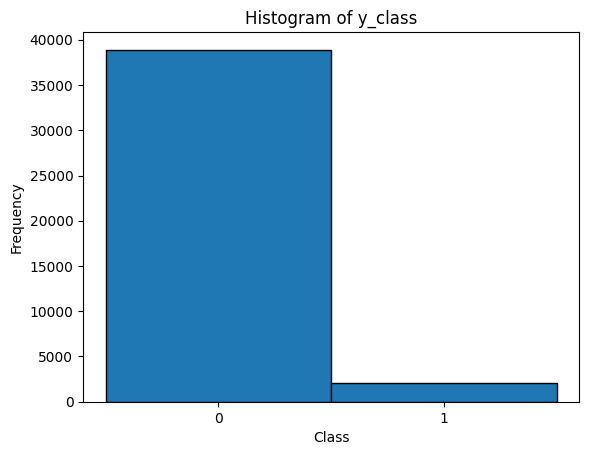

In [ ]:
y_class = np.array(fb.loc[:,['Comments']].values > np.quantile(fb.loc[:,['Comments']].values, 0.95), dtype = int)

# histogram
plt.hist(y_class, bins=[-.5,.5,1.5], edgecolor='black')
plt.xticks([0,1])
plt.title('Histogram of y_class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Checking the imbalance
num_zeros = (y_class == 0).sum()
num_ones = (y_class == 1).sum()
total = num_zeros + num_ones

print(f"Number of 0's: {num_zeros} ({(num_zeros/total)*100:.2f}%)")
print(f"Number of 1's: {num_ones} ({(num_ones/total)*100:.2f}%)")

Number of 0's: 38902 (95.00%)
Number of 1's: 2047 (5.00%)


So y_class is very imbalanced. Between 0's and 1's 95% of the y_class is comprised of 0's with the remaining 5% of y_class being 1's.

## Part b

Split data into train and test with a test_size = 0.33 and random_sate = 42

Fit the following models
1. Random forest classifier
2. Decision tree classifier
3. Linear Discriminant Analysis
4. Quadratic Disciminant Analysis
5. Logistic Regression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_class, test_size=0.33, random_state=42)
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Linear Discriminant Analysis
lda_classifier = LDA()

# Quadratic Discriminant Analysis
qda_classifier = QDA()

# Logistic Regression
logistic_reg = LogisticRegression(random_state=42)

In [ ]:
# fit
# Random Forest Classifier
rf_classifier.fit(x_train, y_train)

# Decision Tree Classifier
dt_classifier.fit(x_train, y_train)

# Linear Discriminant Analysis
lda_classifier.fit(x_train, y_train)

# Quadratic Discriminant Analysis
qda_classifier.fit(x_train, y_train)

# Logistic Regression
logistic_reg.fit(x_train, y_train)

LogisticRegression(random_state=42)

## Part c

Use each of the five models to predict the class labels (1 or 0) and the class probabilities on the test set. You do not need to calculate for the training dataset.

In [ ]:
# predict labels (1 or 0)
rf_predictions = rf_classifier.predict(x_test)
dt_predictions = dt_classifier.predict(x_test)
lda_predictions = lda_classifier.predict(x_test)
qda_predictions = qda_classifier.predict(x_test)
logistic_reg_predictions = logistic_reg.predict(x_test)
# predict proba
rf_class_probabilities = rf_classifier.predict_proba(x_test)
dt_class_probabilities = dt_classifier.predict_proba(x_test)
lda_class_probabilities = lda_classifier.predict_proba(x_test)
qda_class_probabilities = qda_classifier.predict_proba(x_test)
logistic_reg_class_probabilities = logistic_reg.predict_proba(x_test)

## Part d

Compute and print

1. The test accuracy of each model
2. The test Brier score of each model
3. The test log score of each model

Make sure each print statement clearly indicates the model type (random forest, decision tree, etc.) and rounds to 3 decimal places.

Comment on which model is the best based on these metrics and which is the worst. If no model dominates the other in terms of Brier and Log score then comment on which two models are "equally" best. Your response should be several sentences long.

In [ ]:
# accuracy, brier, log
from sklearn.metrics import accuracy_score, brier_score_loss, log_loss

# Calculate and print the test accuracy, Brier score, and log score for each model
models = [rf_classifier, dt_classifier, lda_classifier, qda_classifier, logistic_reg]
model_names = ["Random Forest", "Decision Tree", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "Logistic Regression"]

for model, model_name in zip(models, model_names):
    predictions = model.predict(x_test)
    class_probabilities = model.predict_proba(x_test)

    accuracy = accuracy_score(y_test, predictions)
    brier_score = brier_score_loss(y_test, class_probabilities[:, 1])
    log_score = log_loss(y_test, class_probabilities)

    print(f"{model_name} - Test Accuracy: {accuracy:.3f}")
    print(f"{model_name} - Test Brier Score: {brier_score:.3f}")
    print(f"{model_name} - Test Log Score: {log_score:.3f}")
    print()



Random Forest - Test Accuracy: 0.965
Random Forest - Test Brier Score: 0.025
Random Forest - Test Log Score: 0.094

Decision Tree - Test Accuracy: 0.955
Decision Tree - Test Brier Score: 0.045
Decision Tree - Test Log Score: 1.635

Linear Discriminant Analysis - Test Accuracy: 0.962
Linear Discriminant Analysis - Test Brier Score: 0.034
Linear Discriminant Analysis - Test Log Score: 0.198

Quadratic Discriminant Analysis - Test Accuracy: 0.591
Quadratic Discriminant Analysis - Test Brier Score: 0.383
Quadratic Discriminant Analysis - Test Log Score: 6.316

Logistic Regression - Test Accuracy: 0.948
Logistic Regression - Test Brier Score: 0.079
Logistic Regression - Test Log Score: 0.339



Overall, , the **Random Forest** and **Linear Discriminant Analysis** models stand out as the top performers, with **Random Forest** sliglhtly better because of it having the highest accuracy and the lowest Brier score. **Quadratic Discriminant Analysis** lags behind the other models in terms of all 3 metrics tested, making it the weakest performer in this setting.

## Part e

Maybe theres no clear winner or maybe you think these metrics are "too close to call", so we invesigate these models further by looking at their ROC curves and AUC.

Compute and show

1. The ROC curve for each model (all overlaid in one plot)
2. The AUC for each model (print and label)

Comment on how these models compare in terms of ROC and AUC.  Your response should be several sentences long.

In [ ]:
# compute roc curves

fpr_list = []
tpr_list = []

for model in models:
    class_probabilities = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, class_probabilities)
    fpr_list.append(fpr)
    tpr_list.append(tpr)




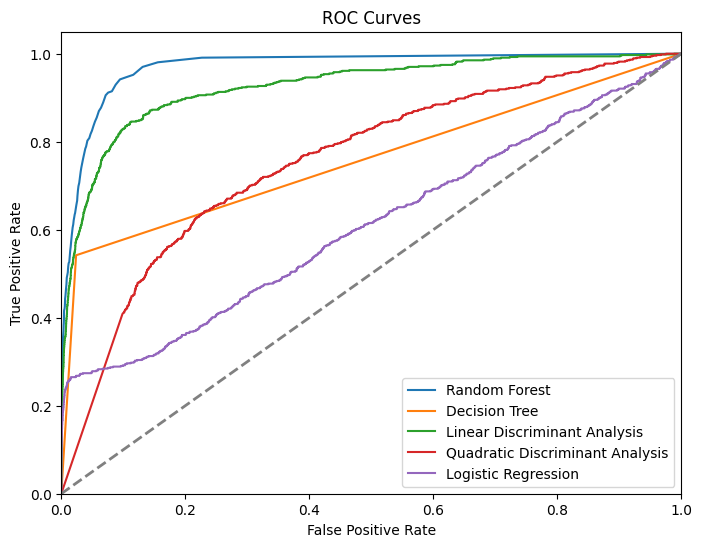

In [ ]:
# plot and label roc curves
plt.figure(figsize=(8, 6))
for model_name, fpr, tpr in zip(model_names, fpr_list, tpr_list):
    plt.plot(fpr, tpr, label=model_name)

plt.plot([0, 1], [0, 1], 'k--', color='gray', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# auc
# Initialize a list to store AUC values for each model
auc_list = []

# Calculate AUC for each model
for model, model_name in zip(models, model_names):
    class_probabilities = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, class_probabilities)
    auc_list.append(auc)

# Print the AUC for each model
for model_name, auc in zip(model_names, auc_list):
    print(f"{model_name} - AUC: {auc:.3f}")

Random Forest - AUC: 0.970
Decision Tree - AUC: 0.759
Linear Discriminant Analysis - AUC: 0.926
Quadratic Discriminant Analysis - AUC: 0.756
Logistic Regression - AUC: 0.609


Based on the ROC curve, **Random Forest** is performing the best since it is the curve in the most top left corner. LDA is a close second best. The worst in performance is **Logistic Regression**.
Based on the AUC value, **Random Forest** is the best since it has the highest score. **Logistic Regression** performs the worse with the lowest AUC score.

## Part f

Suppose we ultimately choose the random forest regarless of your findings above. (your boss says you have to)

Lets see what the random forest think is important

1. Print the feature importance of each feature in a table format. Each row should include the feature name and its importance to the RF classifier

In [ ]:
feature_importances = rf_classifier.feature_importances_
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Sort the features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                  Feature  Importance
5                     CC2    0.228857
8                     CC5    0.172239
10       Post Share Count    0.106915
7                     CC4    0.077532
2      Page Talking About    0.070238
4                     CC1    0.070069
9             Post Length    0.067410
0   Page Popularity Likes    0.060014
3           Page Category    0.035646
6                     CC3    0.034643
1           Page Checkins    0.033716
17        Posted Saturday    0.007818
14       Posted Wednesday    0.007639
12          Posted Monday    0.007578
15        Posted Thursday    0.006946
16          Posted Friday    0.006398
13         Posted Tuesday    0.006342
11  Post Promotion Status    0.000000


## Part g

That list tells us what is important but not what makes it important

Lets investigate a single feature -- `Post Length`

1. Display a scatter plot of `log(post length + 1)` against the predicted probability (from the random forest) of being in the top 5\%.
2. Comment on the pattern.

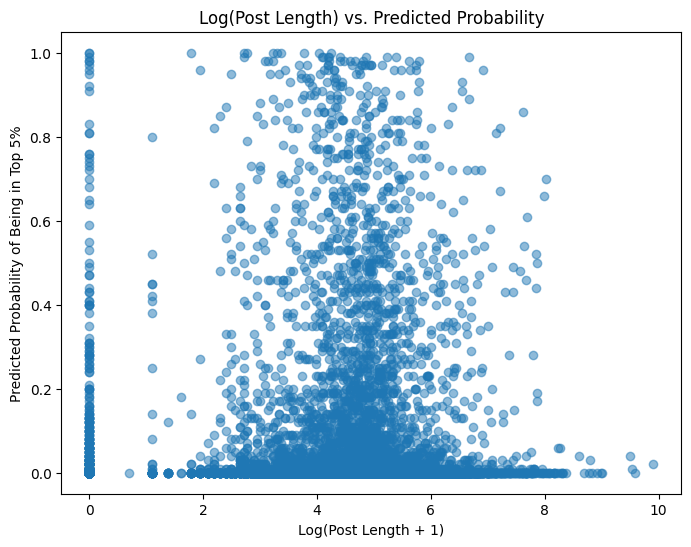

In [ ]:
# plot log post length against the prediced probability
predicted_probabilities = rf_classifier.predict_proba(x_test)[:, 1]
post_length = x_test['Post Length']
log_post_length = np.log(post_length + 1)
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(log_post_length, predicted_probabilities, alpha=0.5)
plt.xlabel('Log(Post Length + 1)')
plt.ylabel('Predicted Probability of Being in Top 5%')
plt.title('Log(Post Length) vs. Predicted Probability')
plt.show()


There is a central concentration and outliers. The pattern suggests that post length alone may not be the sole determinant of high activity.

# Question 3 - Image classification and sample size

This question isnt really about image classification. This question is about how models improve with increasing amounts of training data. We will fit two models (random forest and logistic regression) to the CIFAR10 dataset of natural images.
* https://www.cs.toronto.edu/~kriz/cifar.html

Our goal is to see how (or if) test error metrics improve with increasing levels of training data and how that differs by model.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified


### Part a

Loop through the `training_data` object and extract all of the images (flattened to a vector) and the labels.

1. Extract all images. Flatten them to vectors and store in the matrix `x`.
2. Extract the associated class labels. Store them in the vector `y`.

In [ ]:
x = np.zeros((50000, 3*32*32))
y = np.zeros(50000)


for i in trange(len(training_data)):
  img, label = training_data[i]
  x[i] = img.flatten()
  y[i] = label


  0%|          | 0/50000 [00:00<?, ?it/s]

## Part b

We will train two models 3 times each to see how increasing the training sample size can help improve out of sample performance.

1. Train a random forest and a logistic regression on 1\% of the data. Save the brier score, accuracy and average F1 score of each model.
2. Repeat step 1 but train on 5\% of the data.
3. Repeat step 1 but train on 25% of the data (slow).

## Train 1% of the data

In [ ]:
from sklearn.metrics import f1_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.99, random_state=42)


rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)

# random forest
yhat_rfc_test = rfc.predict(x_test)

phat_rfc_test = rfc.predict_proba(x_test)

from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

brierscore1 = brier_score(y_test, phat_rfc_test)

accuracy1 = accuracy_score(y_test, yhat_rfc_test)

f1_1 = f1_score(y_test, yhat_rfc_test, average='macro')

print('Random Forest')
print('Brier score')
print('RFC Test:', np.round(brierscore1, 3))
print('')
print('Accuracy')
print(np.round(accuracy1, 3))
print('')
print('F1 Score')
print( np.round(f1_1, 3))

Random Forest
Brier score
RFC Test: 0.816

Accuracy
0.298

F1 Score
0.283


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.99, random_state=42)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

# Logistic Regression predictions
yhat_lr_test = lr.predict(x_test)

phat_lr_test = lr.predict_proba(x_test)

brierscore_lr1 = brier_score(y_test, phat_lr_test)

accuracy_lr1 = accuracy_score(y_test, yhat_lr_test)

f1_lr1 = f1_score(y_test, yhat_lr_test, average='macro')

print('Logistic Regression ')
print('Brier score', np.round(brierscore_lr1, 3))
print('')
print('Accuracy')
print(np.round(accuracy_lr1, 3))
print('')
print('F1 Score')
print(np.round(f1_lr1, 3))


Logistic Regression 
Brier score 1.055

Accuracy
0.262

F1 Score
0.259


##Train 5% of the data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95, random_state=42)


rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)

# random forest
yhat_rfc_test = rfc.predict(x_test)

phat_rfc_test = rfc.predict_proba(x_test)

from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

brierscore5 = brier_score(y_test, phat_rfc_test)

accuracy5 = accuracy_score(y_test, yhat_rfc_test)

f1_5 = f1_score(y_test, yhat_rfc_test, average='macro')


print('Random Forest')
print('Brier score')
print('RFC Test:', np.round(brierscore5, 3))
print('')
print('Accuracy')
print(np.round(accuracy5, 3))
print('')
print('F1 Score')
print( np.round(f1_5, 3))

Random Forest
Brier score
RFC Test: 0.779

Accuracy
0.364

F1 Score
0.358


In [ ]:
# Assuming x and y are your features and labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95, random_state=42)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

# Logistic Regression predictions
yhat_lr_test = lr.predict(x_test)

phat_lr_test = lr.predict_proba(x_test)

brierscore_lr5 = brier_score(y_test, phat_lr_test)

accuracy_lr5 = accuracy_score(y_test, yhat_lr_test)

f1_lr5 = f1_score(y_test, yhat_lr_test, average='macro')

print('Logistic Regression ')
print('Brier score', np.round(brierscore_lr5, 3))
print('')
print('Accuracy')
print(np.round(accuracy_lr5, 3))
print('')
print('F1 Score')
print(np.round(f1_lr5, 3))


Logistic Regression 
Brier score 0.898

Accuracy
0.316

F1 Score
0.314


##Train 25% of data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.75, random_state=42)


rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)

# random forest
yhat_rfc_test = rfc.predict(x_test)

phat_rfc_test = rfc.predict_proba(x_test)

from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

brierscore25 = brier_score(y_test, phat_rfc_test)
accuracy25 = accuracy_score(y_test, yhat_rfc_test)

f1_25 = f1_score(y_test, yhat_rfc_test, average='macro')


print('Random Forest')
print('Brier score')
print('RFC Test:', np.round(brierscore25, 3))
print('')
print('Accuracy')
print(np.round(accuracy25, 3))
print('')
print('F1 Score')
print( np.round(f1_25, 3))

Random Forest
Brier score
RFC Test: 0.745

Accuracy
0.419

F1 Score
0.415


In [ ]:
# Assuming x and y are your features and labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.75, random_state=42)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)

# Logistic Regression predictions
yhat_lr_test = lr.predict(x_test)

phat_lr_test = lr.predict_proba(x_test)

brierscore_lr25 = brier_score(y_test, phat_lr_test)

accuracy_lr25 = accuracy_score(y_test, yhat_lr_test)

f1_lr25 = f1_score(y_test, yhat_lr_test, average='macro')

print('Logistic Regression ')
print('Brier score', np.round(brierscore_lr25, 3))
print('')
print('Accuracy')
print(np.round(accuracy_lr25, 3))
print('')
print('F1 Score')
print(np.round(f1_lr25, 3))


Logistic Regression 
Brier score 0.763

Accuracy
0.379

F1 Score
0.376


In [ ]:
#List of scores
rf_brierscores=[brierscore1, brierscore5, brierscore25]
rf_accuracy=[accuracy1, accuracy5, accuracy25]
rf_f1score=[f1_1, f1_5, f1_25]
lr_brierscores=[brierscore_lr1, brierscore_lr5, brierscore_lr25]
lr_accuracy=[accuracy_lr1, accuracy_lr5, accuracy_lr25]
lr_f1score=[f1_lr1, f1_lr5, f1_lr25]


## Part c

Now lets compare how each model performed as we increased the amount of training data available.

1. Plot the brier score for each model as a function of training sample size. Color code each line by model type (randomforest and logistic regression).
2. Repeat for Accuracy and F1 score metrics. Combine all three plots into a single multi-panel (1 row, 3 col) plot.
3. Which model seemed to improve the most with increasing sample size? Answer using all of the plotted metrics.
4. Does this make sense given what we know about parametric and nonparametric models? Why might one of these models be benefitting more from having more training data?
5

##Part 1

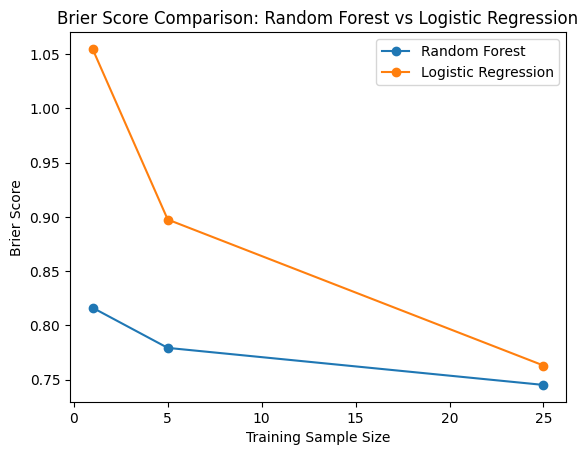

In [ ]:
training_sizes = [1, 5, 25]
# Brier scores for Random Forest
rf_brierscores = [brierscore1, brierscore5, brierscore25]
# Brier scores for Logistic Regression
lr_brierscores = [brierscore_lr1, brierscore_lr5, brierscore_lr25]
# Plotting
plt.plot(training_sizes, rf_brierscores, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_brierscores, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('Brier Score')
plt.title('Brier Score Comparison: Random Forest vs Logistic Regression')
plt.legend()
plt.show()


##Part 2

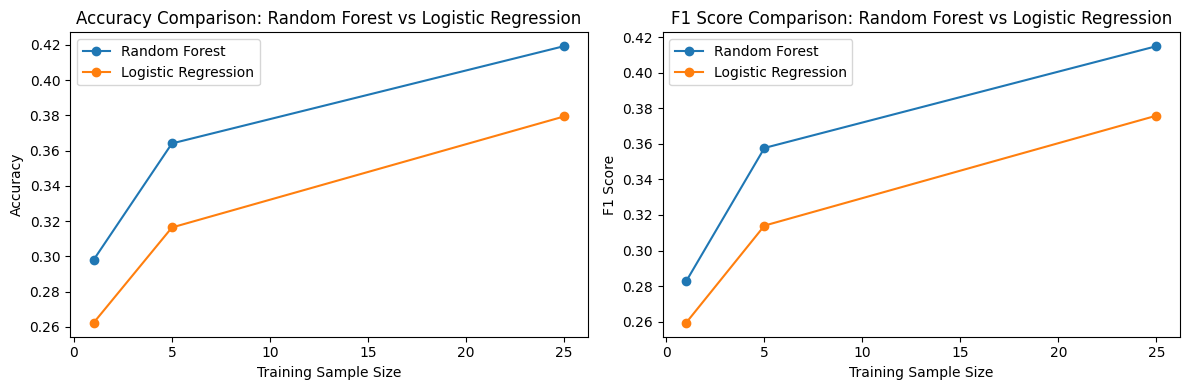

In [ ]:
training_sizes = [1, 5, 25]
# Random Forest
rf_accuracy = [accuracy1, accuracy5, accuracy25]
rf_f1score = [f1_1, f1_5, f1_25]
#Logistic Regression
lr_accuracy = [accuracy_lr1, accuracy_lr5, accuracy_lr25]
lr_f1score = [f1_lr1, f1_lr5, f1_lr25]
# Plotting Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_sizes, rf_accuracy, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_accuracy, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Random Forest vs Logistic Regression')
plt.legend()
# Plotting F1 Score
plt.subplot(1, 2, 2)
plt.plot(training_sizes, rf_f1score, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_f1score, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison: Random Forest vs Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()


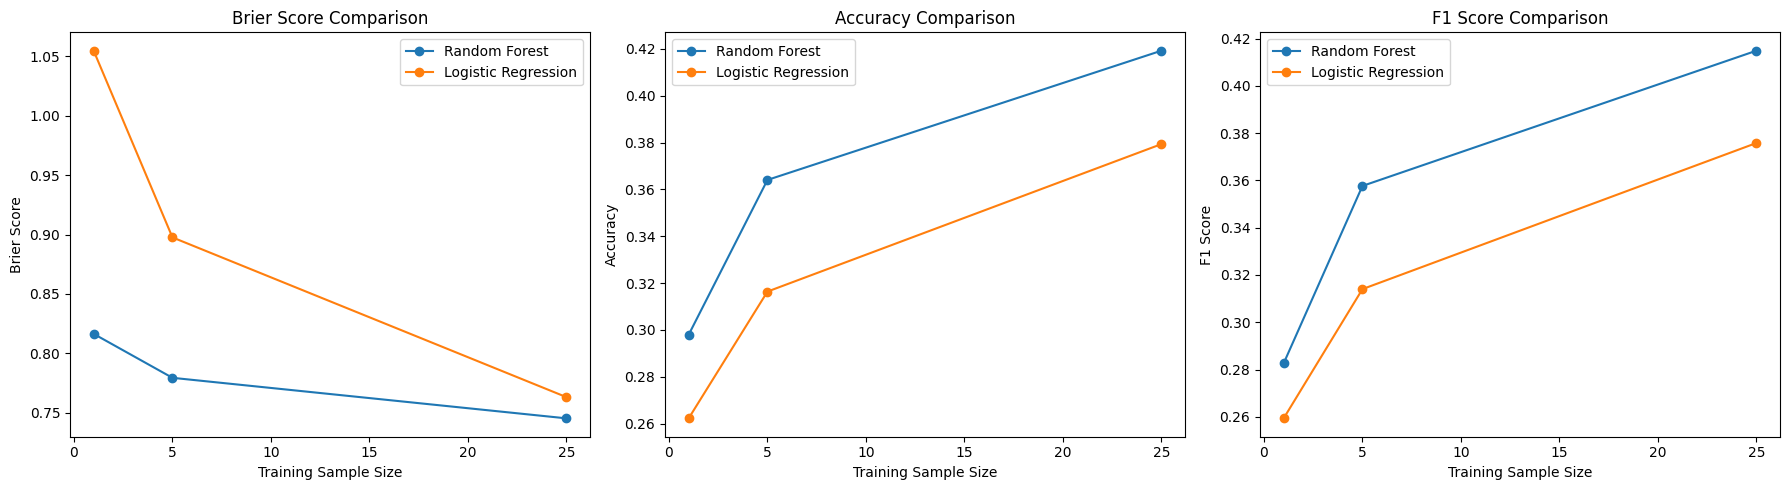

In [ ]:
training_sizes = [1, 5, 25]
# Random Forest
rf_brierscores = [brierscore1, brierscore5, brierscore25]
rf_accuracy = [accuracy1, accuracy5, accuracy25]
rf_f1score = [f1_1, f1_5, f1_25]
# Logistic Regression
lr_brierscores = [brierscore_lr1, brierscore_lr5, brierscore_lr25]
lr_accuracy = [accuracy_lr1, accuracy_lr5, accuracy_lr25]
lr_f1score = [f1_lr1, f1_lr5, f1_lr25]
# Create a multi-panel plot (1 row, 3 columns)
plt.figure(figsize=(18, 5))
# Plotting Brier Scores
plt.subplot(1, 3, 1)
plt.plot(training_sizes, rf_brierscores, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_brierscores, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('Brier Score')
plt.title('Brier Score Comparison')
plt.legend()
# Plotting Accuracy
plt.subplot(1, 3, 2)
plt.plot(training_sizes, rf_accuracy, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_accuracy, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
# Plotting F1 Score
plt.subplot(1, 3, 3)
plt.plot(training_sizes, rf_f1score, marker='o', linestyle='-', label='Random Forest')
plt.plot(training_sizes, lr_f1score, marker='o', linestyle='-', label='Logistic Regression')
plt.xlabel('Training Sample Size')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend()
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()



##Part 3

In both models, the Brier Score decreases, and the Accuracy and F1 Score increase as the training sample size goes from 1% to 25%. But, the improvement is more pronounced for the Random Forest model, therefore, it seems that the Random Forest model improved more with increasing sample size across all the metrics.

##Part 4

Nonparametric models like Random Forest can leverage larger datasets to capture more complex patterns, whereas parametric models may have limitations in representing highly intricate relationships. The observed improvement in Random Forest with increasing sample size aligns with the characteristics of
nonparametric models.

##Part 5

None of these models are close in accuracy to what is listed on the CIFAR10 page.